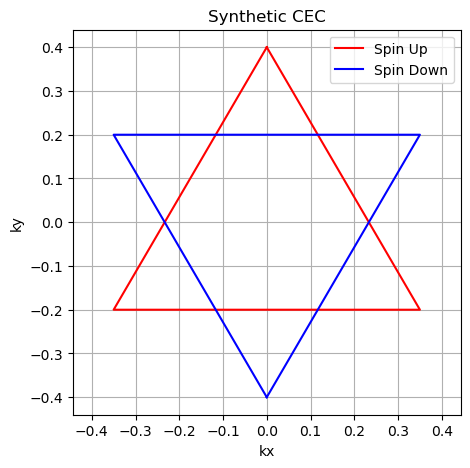

✅ Files generated:
 - spin_up.csv
 - spin_down.csv
 - total_CEC.csv
 - synthetic_cec.png


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === Step 1: Define synthetic CECs for spin up and spin down ===

# Triangle for spin up
triangle_up = np.array([
    [ 0.0,  0.4],
    [-0.35, -0.2],
    [ 0.35, -0.2],
    [ 0.0,  0.4]  # close the loop
])

# Triangle for spin down
triangle_down = np.array([
    [ 0.0, -0.4],
    [-0.35,  0.2],
    [ 0.35,  0.2],
    [ 0.0, -0.4]  # close the loop
])

# Add intensity = 1.0 to each point
spin_up = np.hstack([triangle_up, np.ones((triangle_up.shape[0], 1))])
spin_down = np.hstack([triangle_down, np.ones((triangle_down.shape[0], 1))])
total_cec = np.vstack([spin_up, spin_down])

# === Step 2: Save to CSV ===
pd.DataFrame(spin_up, columns=['kx', 'ky', 'intensity']).to_csv('spin_up.csv', index=False)
pd.DataFrame(spin_down, columns=['kx', 'ky', 'intensity']).to_csv('spin_down.csv', index=False)
pd.DataFrame(total_cec, columns=['kx', 'ky', 'intensity']).to_csv('total_CEC.csv', index=False)

# === Step 3: Plot and save image ===
plt.figure(figsize=(5, 5))
plt.plot(spin_up[:, 0], spin_up[:, 1], 'r-', label='Spin Up')
plt.plot(spin_down[:, 0], spin_down[:, 1], 'b-', label='Spin Down')
plt.title("Synthetic CEC")
plt.xlabel("kx")
plt.ylabel("ky")
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.savefig('synthetic_cec.png', dpi=300)
plt.show()

print("✅ Files generated:")
print(" - spin_up.csv")
print(" - spin_down.csv")
print(" - total_CEC.csv")
print(" - synthetic_cec.png")


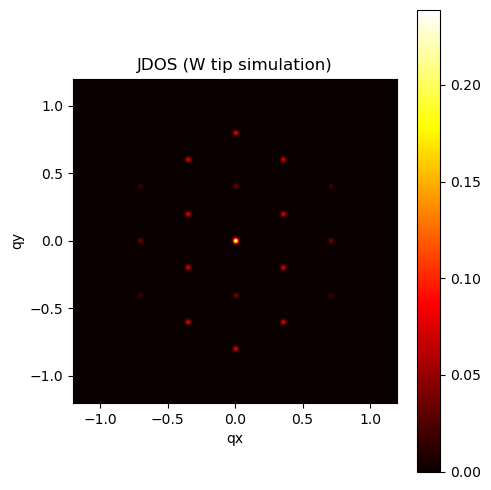

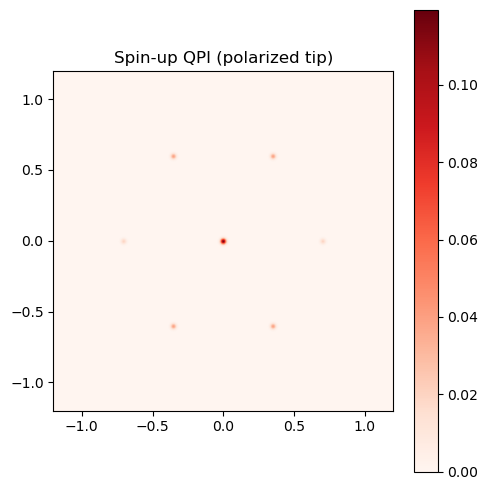

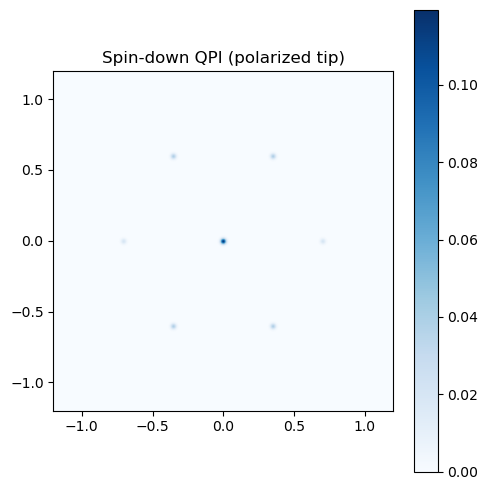

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

def points_to_density_map(points, grid_size=512, k_range=1.0, sigma=2.0):
    """
    Convert (kx, ky, intensity) points into a 2D density map over [-k_range, k_range]
    """
    kx, ky, I = points[:,0], points[:,1], points[:,2]
    density = np.zeros((grid_size, grid_size))

    # Define coordinate grid
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)

    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]  # note: image-style indexing

    # Gaussian smooth
    density = gaussian_filter(density, sigma=sigma)
    return density

def compute_jdos(density_map):
    """
    Compute JDOS via autocorrelation (FFT^(-1) |FFT|^2)
    """
    fft = np.fft.fft2(density_map)
    jdos = np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))
    return jdos

# Load data from CSV
up = pd.read_csv('spin_up.csv').values
dn = pd.read_csv('spin_down.csv').values
total = pd.read_csv('total_CEC.csv').values

# Convert to density maps
grid_size = 512
sigma = 2.0
k_range = 1.2  # sets k-space range from -1.2 to 1.2 Å⁻¹

map_up = points_to_density_map(up, grid_size, k_range, sigma)
map_dn = points_to_density_map(dn, grid_size, k_range, sigma)
map_total = map_up + map_dn

# Compute JDOS / QPI maps
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

# === Plot ===
extent = [-k_range, k_range, -k_range, k_range]

plt.figure(figsize=(5,5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip simulation)")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig("JDOS_W_tip.png", dpi=300)

plt.figure(figsize=(5,5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig("JDOS_spin_up.png", dpi=300)

plt.figure(figsize=(5,5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig("JDOS_spin_down.png", dpi=300)

plt.show()


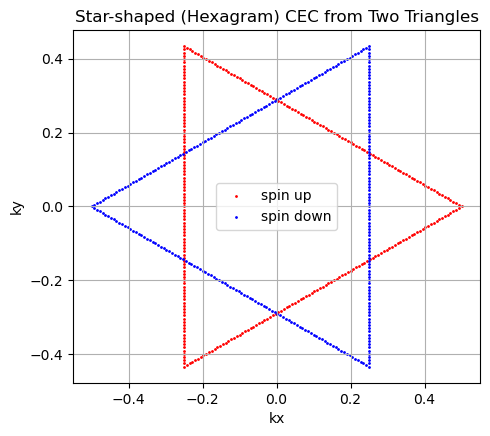

✅ Star CEC files saved:
 - spin_up_star.csv
 - spin_down_star.csv
 - total_CEC_star.csv
 - star_CEC.png


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def triangle_contour(n_points=300, center=(0,0), radius=0.5, rotation=0.0):
    """
    Generate n_points uniformly sampled along an equilateral triangle contour
    """
    cx, cy = center
    angles = np.linspace(0, 2 * np.pi, 4)[:-1] + rotation  # 3 vertices
    vertices = np.stack([radius * np.cos(angles), radius * np.sin(angles)], axis=1) + center

    # Interpolate between triangle edges
    points = []
    for i in range(3):
        start = vertices[i]
        end = vertices[(i+1)%3]
        for t in np.linspace(0, 1, n_points//3, endpoint=False):
            pt = (1-t)*start + t*end
            points.append(pt)

    points = np.array(points)
    intensity = np.ones((points.shape[0], 1))
    return np.hstack([points, intensity])

# === Generate two triangles centered at same point, rotated 180° ===
spin_up = triangle_contour(n_points=300, center=(0, 0), radius=0.5, rotation=0)
spin_dn = triangle_contour(n_points=300, center=(0, 0), radius=0.5, rotation=np.pi)

# Merge into full CEC
spin_total = np.vstack([spin_up, spin_dn])

# === Save to new files (with _star suffix to distinguish) ===
pd.DataFrame(spin_up, columns=['kx','ky','intensity']).to_csv('spin_up_star.csv', index=False)
pd.DataFrame(spin_dn, columns=['kx','ky','intensity']).to_csv('spin_down_star.csv', index=False)
pd.DataFrame(spin_total, columns=['kx','ky','intensity']).to_csv('total_CEC_star.csv', index=False)

# === Plot ===
plt.figure(figsize=(5,5))
plt.scatter(spin_up[:,0], spin_up[:,1], s=1, c='r', label='spin up')
plt.scatter(spin_dn[:,0], spin_dn[:,1], s=1, c='b', label='spin down')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Star-shaped (Hexagram) CEC from Two Triangles")
plt.xlabel("kx")
plt.ylabel("ky")
plt.tight_layout()
plt.savefig("star_CEC.png", dpi=300)
plt.show()

print("✅ Star CEC files saved:")
print(" - spin_up_star.csv")
print(" - spin_down_star.csv")
print(" - total_CEC_star.csv")
print(" - star_CEC.png")


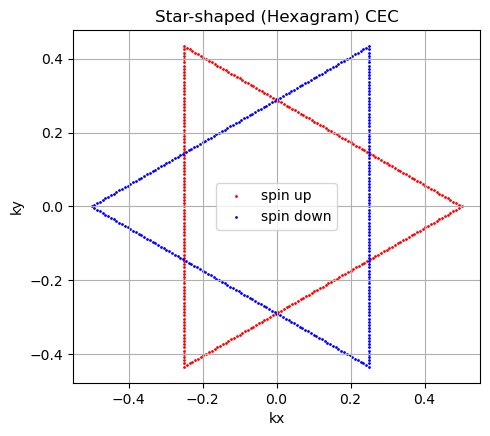

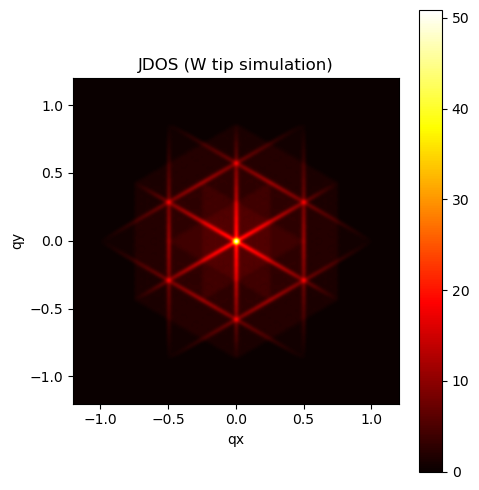

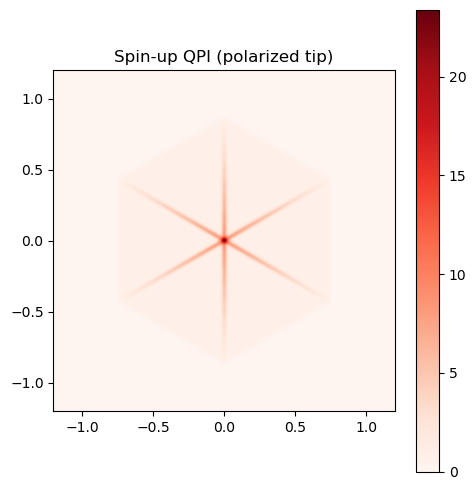

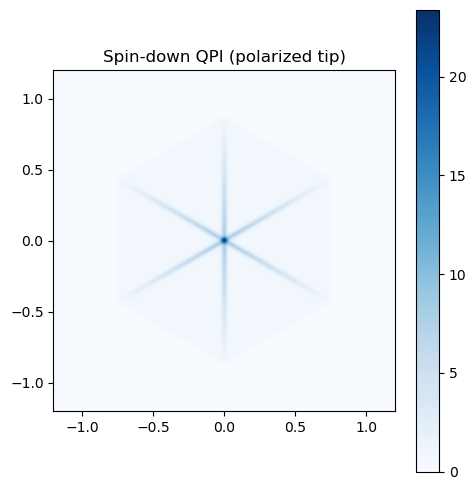

✅ All star-shaped CEC & QPI data and plots saved in folder: output_star_jdos


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# === Output directory ===
output_dir = "output_star_jdos"
os.makedirs(output_dir, exist_ok=True)

def triangle_contour(n_points=300, center=(0,0), radius=0.5, rotation=0.0):
    """Generate n_points along a triangle contour"""
    cx, cy = center
    angles = np.linspace(0, 2 * np.pi, 4)[:-1] + rotation
    vertices = np.stack([radius * np.cos(angles), radius * np.sin(angles)], axis=1) + center
    points = []
    for i in range(3):
        start = vertices[i]
        end = vertices[(i+1)%3]
        for t in np.linspace(0, 1, n_points//3, endpoint=False):
            pt = (1-t)*start + t*end
            points.append(pt)
    points = np.array(points)
    intensity = np.ones((points.shape[0], 1))
    return np.hstack([points, intensity])

def points_to_density_map(points, grid_size=512, k_range=1.0, sigma=2.0):
    """Convert point list to 2D density map"""
    kx, ky, I = points[:,0], points[:,1], points[:,2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    """Compute JDOS via autocorrelation"""
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

# === Step 1: Generate CEC ===
spin_up = triangle_contour(n_points=300, center=(0, 0), radius=0.5, rotation=0)
spin_dn = triangle_contour(n_points=300, center=(0, 0), radius=0.5, rotation=np.pi)
spin_total = np.vstack([spin_up, spin_dn])

# === Step 2: Save to CSV ===
pd.DataFrame(spin_up, columns=['kx','ky','intensity']).to_csv(
    os.path.join(output_dir, 'spin_up_star.csv'), index=False)
pd.DataFrame(spin_dn, columns=['kx','ky','intensity']).to_csv(
    os.path.join(output_dir, 'spin_down_star.csv'), index=False)
pd.DataFrame(spin_total, columns=['kx','ky','intensity']).to_csv(
    os.path.join(output_dir, 'total_CEC_star.csv'), index=False)

# === Step 3: Plot CEC ===
plt.figure(figsize=(5,5))
plt.scatter(spin_up[:,0], spin_up[:,1], s=1, c='r', label='spin up')
plt.scatter(spin_dn[:,0], spin_dn[:,1], s=1, c='b', label='spin down')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Star-shaped (Hexagram) CEC")
plt.xlabel("kx")
plt.ylabel("ky")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "star_CEC.png"), dpi=300)
plt.show()

# === Step 4: Convert to density map ===
grid_size = 512
k_range = 1.2
sigma = 2.0

map_up = points_to_density_map(spin_up, grid_size, k_range, sigma)
map_dn = points_to_density_map(spin_dn, grid_size, k_range, sigma)
map_total = map_up + map_dn

# === Step 5: Compute JDOS ===
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

# === Step 6: Plot JDOS ===
plt.figure(figsize=(5,5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip simulation)")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_W_tip_star.png"), dpi=300)

plt.figure(figsize=(5,5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_up_star.png"), dpi=300)

plt.figure(figsize=(5,5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_down_star.png"), dpi=300)

plt.show()

print(f"✅ All star-shaped CEC & QPI data and plots saved in folder: {output_dir}")


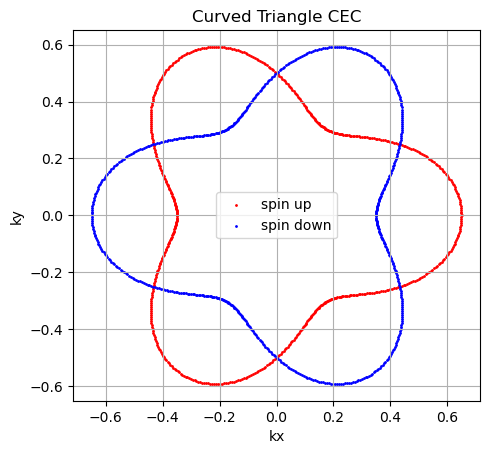

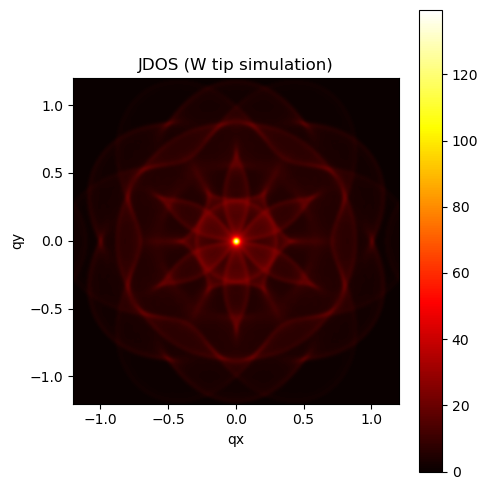

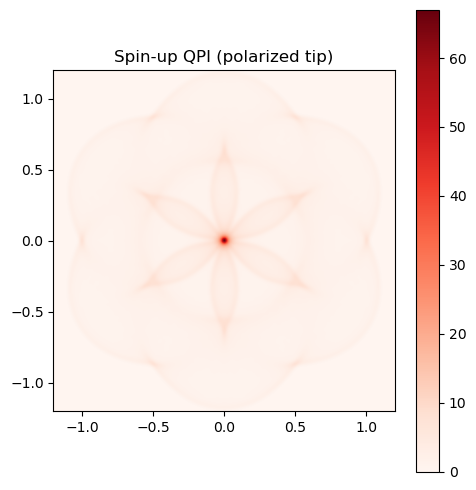

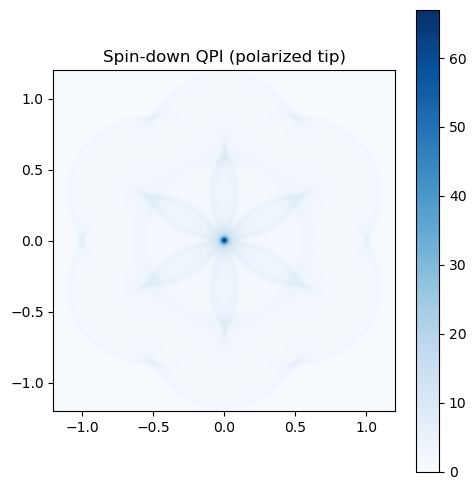

✅ All curved CEC and QPI plots saved in folder: output_curved_triangle_jdos


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# === Output directory ===
output_dir = "output_curved_triangle_jdos"
os.makedirs(output_dir, exist_ok=True)

def curved_triangle_contour(n_points=600, center=(0, 0), r0=0.5, alpha=0.3, rotation=0.0):
    """
    Generate curved triangular CEC: r(θ) = r₀ * [1 + α * cos(3θ)]
    """
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    r = r0 * (1 + alpha * np.cos(3 * theta))
    kx = r * np.cos(theta + rotation) + center[0]
    ky = r * np.sin(theta + rotation) + center[1]
    intensity = np.ones_like(kx)
    return np.vstack([kx, ky, intensity]).T

def points_to_density_map(points, grid_size=512, k_range=1.2, sigma=2.0):
    """Convert CEC points to 2D density map"""
    kx, ky, I = points[:, 0], points[:, 1], points[:, 2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

# === Step 1: Generate curved CECs ===
spin_up = curved_triangle_contour(rotation=0.0)
spin_dn = curved_triangle_contour(rotation=np.pi)
spin_total = np.vstack([spin_up, spin_dn])

# === Step 2: Save to CSV ===
pd.DataFrame(spin_up, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'spin_up_curved.csv'), index=False)
pd.DataFrame(spin_dn, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'spin_down_curved.csv'), index=False)
pd.DataFrame(spin_total, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'total_CEC_curved.csv'), index=False)

# === Step 3: Plot CEC ===
plt.figure(figsize=(5, 5))
plt.scatter(spin_up[:, 0], spin_up[:, 1], s=1, c='r', label='spin up')
plt.scatter(spin_dn[:, 0], spin_dn[:, 1], s=1, c='b', label='spin down')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Curved Triangle CEC")
plt.xlabel("kx")
plt.ylabel("ky")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "curved_CEC.png"), dpi=300)
plt.show()

# === Step 4: Convert to density map ===
grid_size = 512
k_range = 1.2
sigma = 2.0

map_up = points_to_density_map(spin_up, grid_size, k_range, sigma)
map_dn = points_to_density_map(spin_dn, grid_size, k_range, sigma)
map_total = map_up + map_dn

# === Step 5: Compute JDOS ===
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

# === Step 6: Plot JDOS ===
plt.figure(figsize=(5, 5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip simulation)")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_W_tip_curved.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_up_curved.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_down_curved.png"), dpi=300)

plt.show()

print(f"✅ All curved CEC and QPI plots saved in folder: {output_dir}")


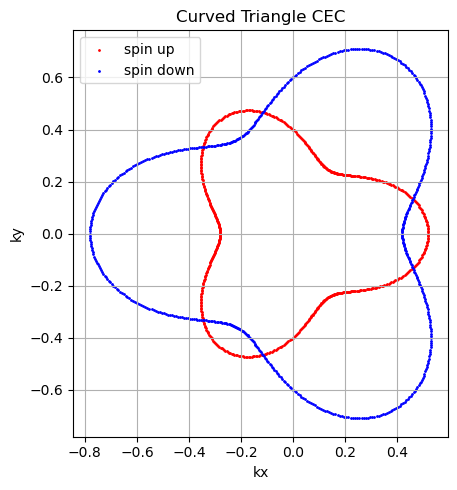

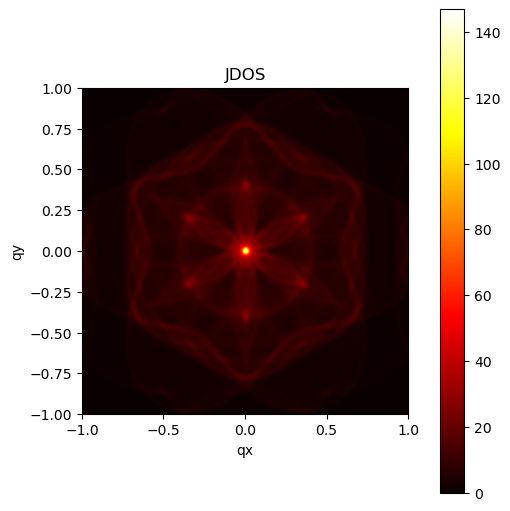

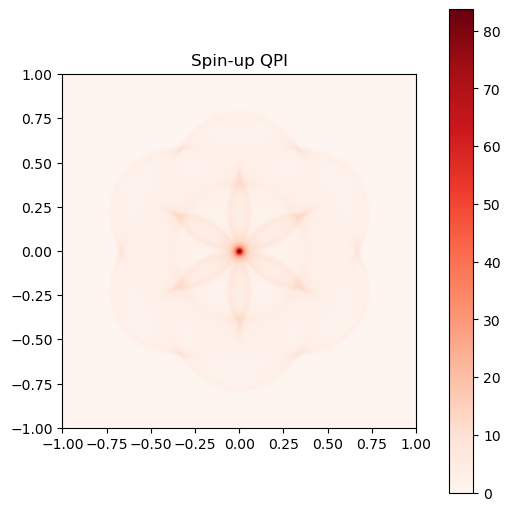

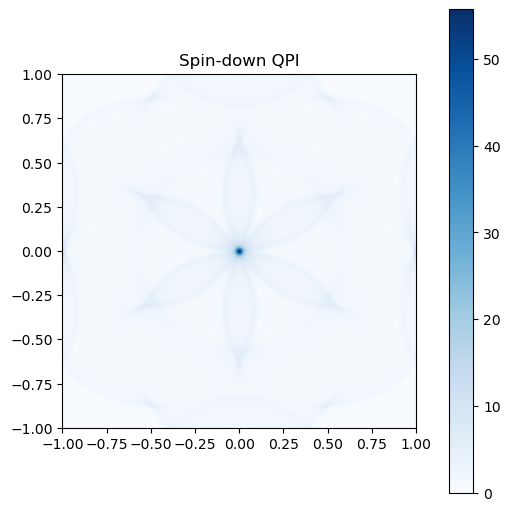

✅ All plots saved in folder: output_curved_triangle_jdos_Bfield_final


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# === Output directory ===
output_dir = "output_curved_triangle_jdos_Bfield_final"
os.makedirs(output_dir, exist_ok=True)

def curved_triangle_contour(n_points=600, center=(0, 0), r0=0.5, alpha=0.3, rotation=0.0):
    theta = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    r = r0 * (1 + alpha * np.cos(3 * theta))
    kx = r * np.cos(theta + rotation) + center[0]
    ky = r * np.sin(theta + rotation) + center[1]
    intensity = np.ones_like(kx)
    return np.vstack([kx, ky, intensity]).T

def points_to_density_map(points, grid_size=512, k_range=1.2, sigma=2.0):
    kx, ky, I = points[:, 0], points[:, 1], points[:, 2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

# === Parameters ===
n_points = 800
grid_size = 512
k_range = 1.2  # 采样范围保持不变
sigma = 2.0
r0 = 0.5
alpha = 0.3
delta = 0.2  # Moderate splitting
extent = [-1, 1, -1, 1]  # JDOS plot 坐标轴范围

# === Generate CECs ===
spin_up = curved_triangle_contour(r0=r0 * (1 - delta), alpha=alpha, rotation=0.0)
spin_dn = curved_triangle_contour(r0=r0 * (1 + delta), alpha=alpha, rotation=np.pi)
spin_total = np.vstack([spin_up, spin_dn])

# === Save CEC points ===
pd.DataFrame(spin_up, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'spin_up_curved_B.csv'), index=False)
pd.DataFrame(spin_dn, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'spin_down_curved_B.csv'), index=False)
pd.DataFrame(spin_total, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'total_CEC_curved_B.csv'), index=False)

# === Plot CEC ===
plt.figure(figsize=(5, 5))
plt.scatter(spin_up[:, 0], spin_up[:, 1], s=1, c='r', label='spin up')
plt.scatter(spin_dn[:, 0], spin_dn[:, 1], s=1, c='b', label='spin down')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Curved Triangle CEC")
plt.xlabel("kx")
plt.ylabel("ky")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "curved_CEC_Bfield.png"), dpi=300, bbox_inches='tight')
plt.show()

# === Density maps ===
map_up = points_to_density_map(spin_up, grid_size, k_range, sigma)
map_dn = points_to_density_map(spin_dn, grid_size, k_range, sigma)
map_total = map_up + map_dn

# === JDOS ===
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

# === Plot JDOS ===
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
im = ax.imshow(jdos_total, cmap='hot', extent=extent)
ax.set_title("JDOS")
ax.set_xlabel("qx")
ax.set_ylabel("qy")
fig.colorbar(im, ax=ax)
fig.savefig(os.path.join(output_dir, "JDOS_W_tip_curved_B.png"), dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
im = ax.imshow(jdos_up, cmap='Reds', extent=extent)
ax.set_title("Spin-up QPI")
fig.colorbar(im, ax=ax)
fig.savefig(os.path.join(output_dir, "JDOS_spin_up_curved_B.png"), dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
im = ax.imshow(jdos_dn, cmap='Blues', extent=extent)
ax.set_title("Spin-down QPI")
fig.colorbar(im, ax=ax)
fig.savefig(os.path.join(output_dir, "JDOS_spin_down_curved_B.png"), dpi=300, bbox_inches='tight')

plt.show()

print(f"✅ All plots saved in folder: {output_dir}")


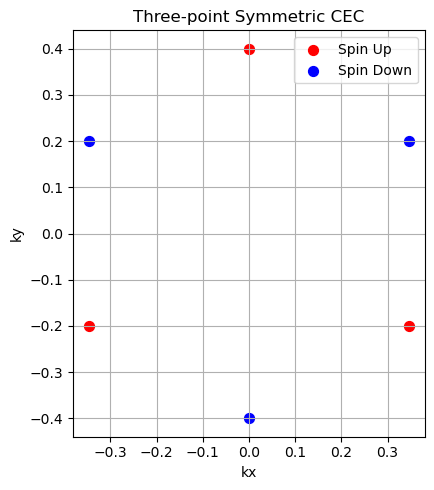

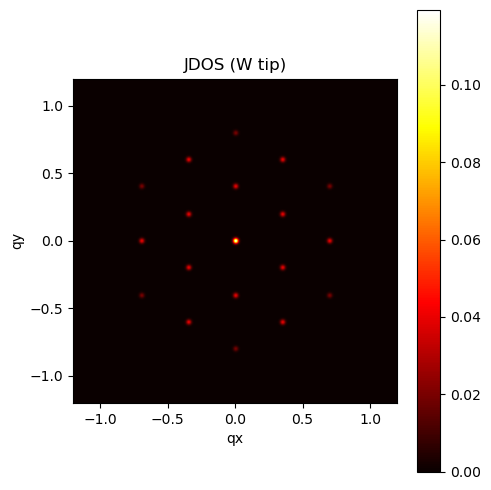

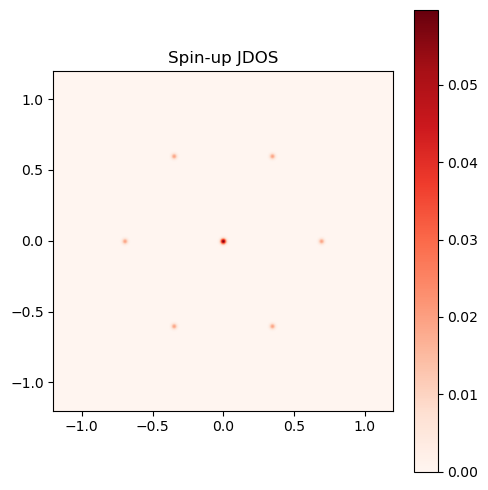

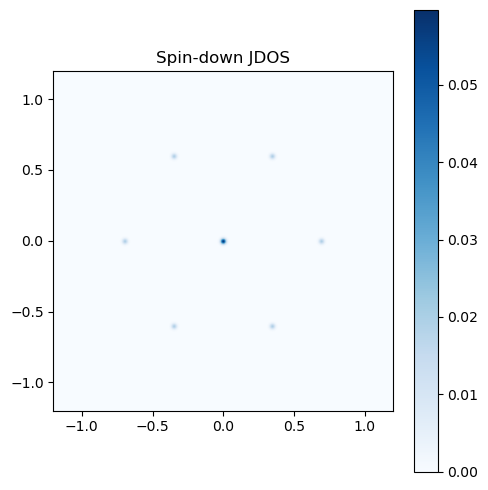

✅ All plots and CSV files saved in folder: output_triangle_jdos


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# === Output directory ===
output_dir = "output_triangle_jdos"
os.makedirs(output_dir, exist_ok=True)

def points_to_density_map(points, grid_size=512, k_range=1.2, sigma=2.0):
    """Convert point list to 2D density map"""
    kx, ky, I = points[:,0], points[:,1], points[:,2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    """Compute JDOS via autocorrelation"""
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

# === Step 1: Define perfectly symmetric triangle ===
triangle_up = np.array([
    [0.0,  0.4],
    [-0.3464, -0.2],
    [ 0.3464, -0.2],
])
triangle_dn = triangle_up * np.array([1, -1])  # mirror along ky

# Add intensity = 1.0
spin_up = np.hstack([triangle_up, np.ones((triangle_up.shape[0], 1))])
spin_dn = np.hstack([triangle_dn, np.ones((triangle_dn.shape[0], 1))])
spin_total = np.vstack([spin_up, spin_dn])

# === Step 2: Save CECs to CSV (optional)
pd.DataFrame(spin_up, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'spin_up_three.csv'), index=False)
pd.DataFrame(spin_dn, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'spin_down_three.csv'), index=False)
pd.DataFrame(spin_total, columns=['kx', 'ky', 'intensity']).to_csv(
    os.path.join(output_dir, 'total_CEC_three.csv'), index=False)

# === Step 3: Plot CEC ===
plt.figure(figsize=(5, 5))
plt.scatter(spin_up[:, 0], spin_up[:, 1], s=50, c='r', label='Spin Up')
plt.scatter(spin_dn[:, 0], spin_dn[:, 1], s=50, c='b', label='Spin Down')
plt.gca().set_aspect('equal')
plt.grid(True)
plt.legend()
plt.title("Three-point Symmetric CEC")
plt.xlabel("kx")
plt.ylabel("ky")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "triangle_CEC.png"), dpi=300)
plt.show()

# === Step 4: Convert to density maps ===
grid_size = 512
k_range = 1.2
sigma = 2.0

map_up = points_to_density_map(spin_up, grid_size, k_range, sigma)
map_dn = points_to_density_map(spin_dn, grid_size, k_range, sigma)
map_total = map_up + map_dn

# === Step 5: JDOS ===
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

# === Step 6: Plot JDOS ===
plt.figure(figsize=(5, 5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip)")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_W_tip_three.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up JDOS")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_up_three.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down JDOS")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_down_three.png"), dpi=300)

plt.show()

print(f"✅ All plots and CSV files saved in folder: {output_dir}")


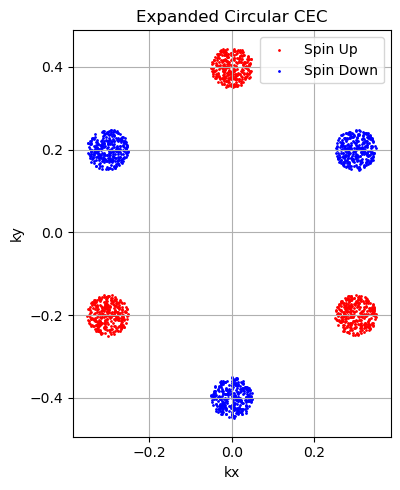

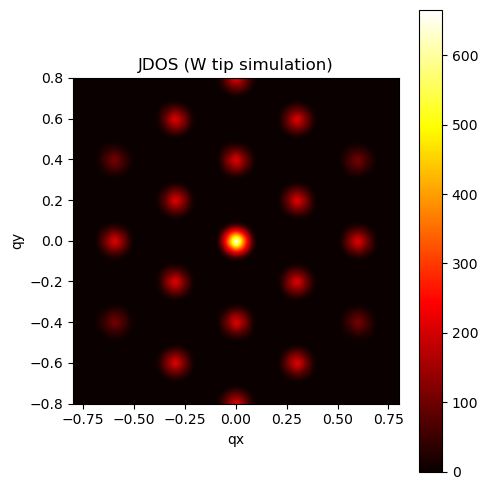

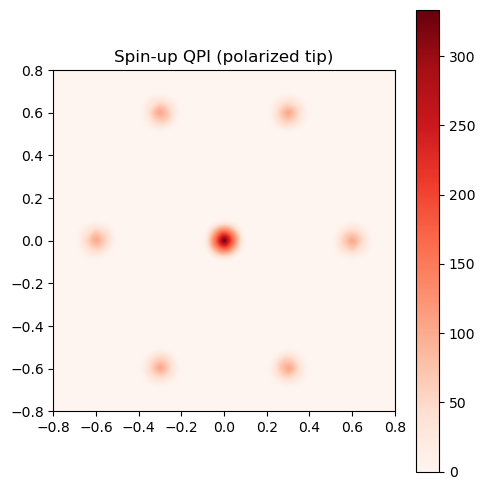

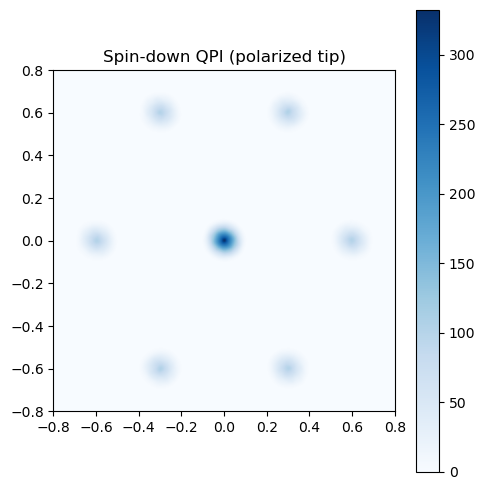

✅ All images saved in folder: output_circular_cec


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# === Output directory ===
output_dir = "output_circular_cec"
os.makedirs(output_dir, exist_ok=True)

def generate_circle_points(center, radius, n_points=200, intensity=1.0):
    """
    Generate uniformly distributed points inside a circle
    """
    r = radius * np.sqrt(np.random.rand(n_points))          # Radial distribution
    theta = 2 * np.pi * np.random.rand(n_points)            # Angular distribution
    kx = center[0] + r * np.cos(theta)
    ky = center[1] + r * np.sin(theta)
    intensity = np.full_like(kx, intensity)
    return np.vstack([kx, ky, intensity]).T

def points_to_density_map(points, grid_size=512, k_range=0.8, sigma=2.0):
    """
    Convert scattered CEC points into a 2D density map with Gaussian smoothing
    """
    kx, ky, I = points[:, 0], points[:, 1], points[:, 2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    """
    Compute the JDOS via autocorrelation (Fourier convolution)
    """
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

# === Parameters ===
radius = 0.05                # Radius of each CEC circle
points_per_circle = 300      # Number of points per CEC circle
grid_size = 512              # Size of the 2D FFT grid
k_range = 0.8                # k-space display range
sigma = 1.5                  # Gaussian smoothing parameter

# === Define six symmetric CEC circle centers (Spin Up and Spin Down) ===
spin_up_centers = [(0, 0.4), (-0.3, -0.2), (0.3, -0.2)]
spin_dn_centers = [(0, -0.4), (-0.3, 0.2), (0.3, 0.2)]

# === Generate points for each CEC ===
spin_up_points = np.vstack([generate_circle_points(c, radius, points_per_circle) for c in spin_up_centers])
spin_dn_points = np.vstack([generate_circle_points(c, radius, points_per_circle) for c in spin_dn_centers])
spin_total_points = np.vstack([spin_up_points, spin_dn_points])

# === Plot the full CECs ===
plt.figure(figsize=(5, 5))
plt.scatter(spin_up_points[:, 0], spin_up_points[:, 1], s=1, c='r', label='Spin Up')
plt.scatter(spin_dn_points[:, 0], spin_dn_points[:, 1], s=1, c='b', label='Spin Down')
plt.title("Expanded Circular CEC")
plt.xlabel("kx")
plt.ylabel("ky")
plt.grid(True)
plt.gca().set_aspect('equal')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "CEC_circular.png"), dpi=300)
plt.show()

# === Convert to density maps ===
map_up = points_to_density_map(spin_up_points, grid_size, k_range, sigma)
map_dn = points_to_density_map(spin_dn_points, grid_size, k_range, sigma)
map_total = map_up + map_dn

# === Compute JDOS ===
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

# === Plot JDOS results ===
plt.figure(figsize=(5, 5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip simulation)")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_W_tip_circular.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_up_circular.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down QPI (polarized tip)")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spin_down_circular.png"), dpi=300)

plt.show()

print(f"✅ All images saved in folder: {output_dir}")


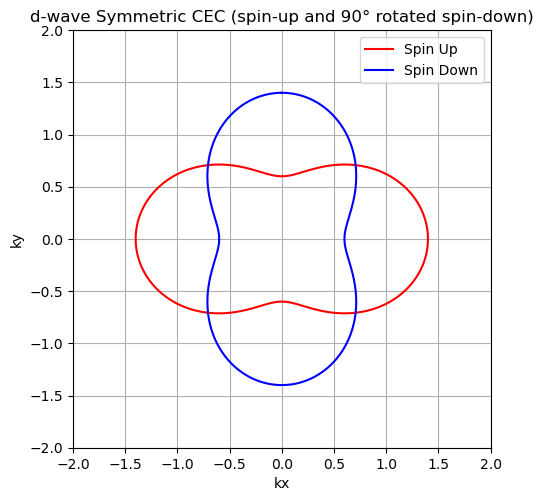

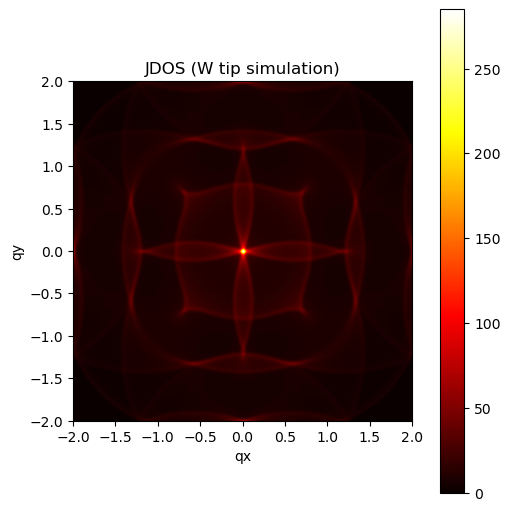

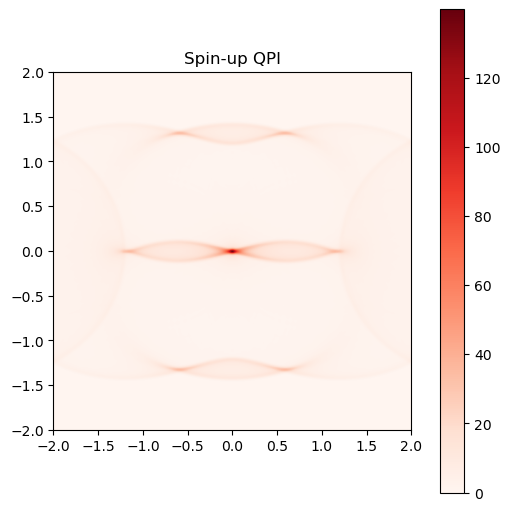

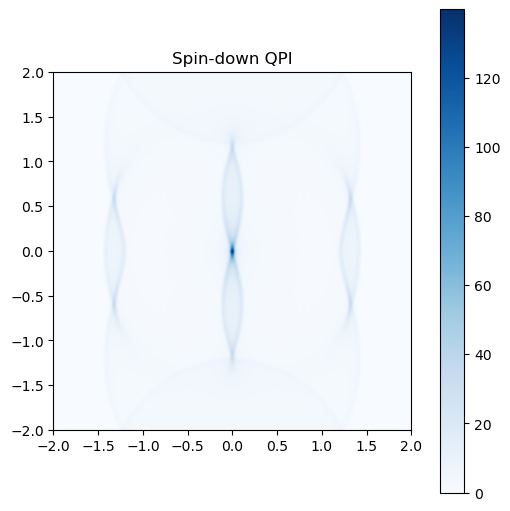

✅ All outputs saved to folder: output_dwave_jdos


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import os

# === Output directory ===
output_dir = "output_dwave_jdos"
os.makedirs(output_dir, exist_ok=True)

def d_wave_cec(n_points=600, kx0=0, ky0=0, r0=1.0, delta=0.4, rotation=0.0):
    """
    Generate d-wave symmetric CEC shape:
    Approximate cos(kx) - cos(ky) = const ("four-lobed" CEC)
    rotation: additional global rotation angle in radians
    """
    theta = np.linspace(0, 2*np.pi, n_points)
    r = r0 * (1 + delta * np.cos(2*theta))  # d-wave modulation
    kx = r * np.cos(theta)
    ky = r * np.sin(theta)
    # Apply rotation
    kx_rot = kx * np.cos(rotation) - ky * np.sin(rotation)
    ky_rot = kx * np.sin(rotation) + ky * np.cos(rotation)
    kx_rot += kx0
    ky_rot += ky0
    intensity = np.ones_like(kx)
    return np.vstack([kx_rot, ky_rot, intensity]).T

def points_to_density_map(points, grid_size=512, k_range=2.0, sigma=2.0):
    """
    Convert CEC points into a 2D density map with Gaussian smoothing
    """
    kx, ky, I = points[:, 0], points[:, 1], points[:, 2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    """
    Compute JDOS = autocorrelation of density map (via Fourier convolution)
    """
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

# === Parameters ===
n_points = 800
grid_size = 512
k_range = 2.0
sigma = 1.5

# === Generate d-wave CEC for spin-up and spin-down (90-degree rotated) ===
spin_up = d_wave_cec(n_points, r0=1.0, delta=0.4, rotation=0.0)
spin_dn = d_wave_cec(n_points, r0=1.0, delta=0.4, rotation=np.pi/2)

# === Plot CEC ===
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
ax.plot(spin_up[:,0], spin_up[:,1], 'r-', label='Spin Up')
ax.plot(spin_dn[:,0], spin_dn[:,1], 'b-', label='Spin Down')
ax.set_aspect('equal')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.grid(True)
ax.legend()
ax.set_title("d-wave Symmetric CEC (spin-up and 90° rotated spin-down)")
ax.set_xlabel("kx")
ax.set_ylabel("ky")
fig.savefig(os.path.join(output_dir, "CEC_dwave.png"), dpi=300, bbox_inches='tight')
plt.show()

# === Convert to density maps ===
map_up = points_to_density_map(spin_up, grid_size, k_range, sigma)
map_dn = points_to_density_map(spin_dn, grid_size, k_range, sigma)
map_total = map_up + map_dn

# === Compute JDOS ===
jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

# === Plot JDOS results ===
fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
im = ax.imshow(jdos_total, cmap='hot', extent=extent)
ax.set_title("JDOS (W tip simulation)")
ax.set_xlabel("qx")
ax.set_ylabel("qy")
fig.colorbar(im, ax=ax)
fig.savefig(os.path.join(output_dir, "JDOS_Wtip_dwave.png"), dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
im = ax.imshow(jdos_up, cmap='Reds', extent=extent)
ax.set_title("Spin-up QPI")
fig.colorbar(im, ax=ax)
fig.savefig(os.path.join(output_dir, "JDOS_spinup_dwave.png"), dpi=300, bbox_inches='tight')

fig, ax = plt.subplots(figsize=(5, 5), constrained_layout=True)
im = ax.imshow(jdos_dn, cmap='Blues', extent=extent)
ax.set_title("Spin-down QPI")
fig.colorbar(im, ax=ax)
fig.savefig(os.path.join(output_dir, "JDOS_spindn_dwave.png"), dpi=300, bbox_inches='tight')

plt.show()

print(f"✅ All outputs saved to folder: {output_dir}")


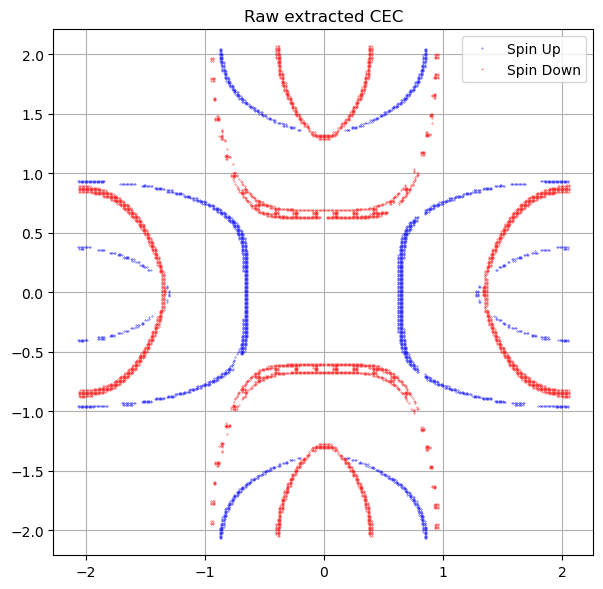

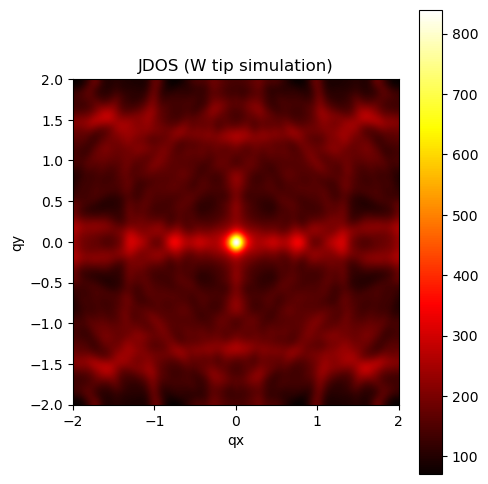

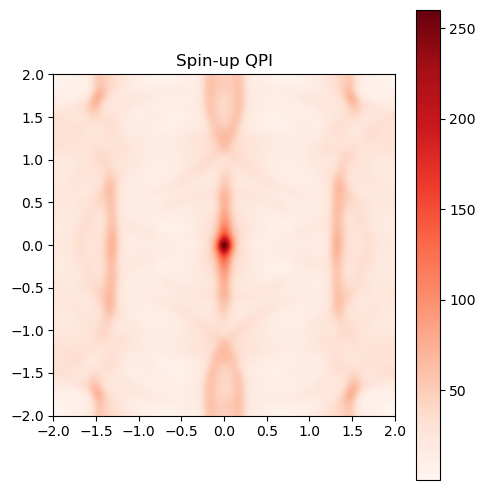

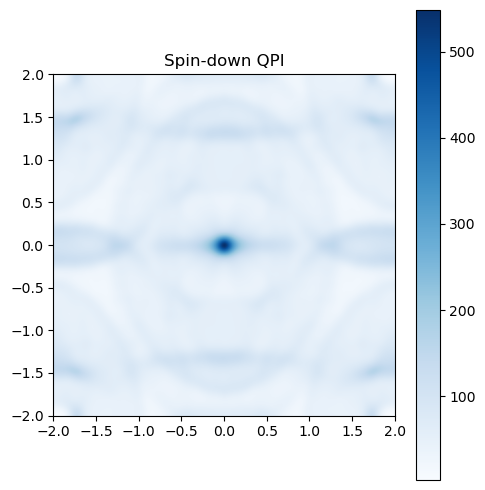

✅ All outputs saved to folder: d_wave_Rb1−δV2Te2O


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import io
import shutil
import os

input_image_path = "d_wave_Rb1−δV2Te2O.png"
output_dir = "d_wave_Rb1−δV2Te2O"
os.makedirs(output_dir, exist_ok=True)

shutil.copy(input_image_path, os.path.join(output_dir, os.path.basename(input_image_path)))

image = io.imread(input_image_path)
if image.shape[-1] == 4:
    image = image[:, :, :3]

red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

red_mask = (red_channel > 150) & (green_channel < 100) & (blue_channel < 100)
blue_mask = (blue_channel > 150) & (red_channel < 100) & (green_channel < 100)

red_y, red_x = np.where(red_mask)
blue_y, blue_x = np.where(blue_mask)

blue_x_norm = (blue_x - np.mean(blue_x)) / 180 * 2
blue_y_norm = (-blue_y - np.mean(-blue_y)) / 180 * 2

red_x_norm = (red_x - np.mean(red_x)) / 180 * 2
red_y_norm = (-red_y - np.mean(-red_y)) / 180 * 2

cec_up = np.vstack([blue_x_norm, blue_y_norm, np.ones_like(blue_x_norm)]).T
cec_dn = np.vstack([red_x_norm, red_y_norm, np.ones_like(red_x_norm)]).T

np.save(os.path.join(output_dir, "cec_up.npy"), cec_up)
np.save(os.path.join(output_dir, "cec_dn.npy"), cec_dn)

plt.figure(figsize=(6, 6))
plt.plot(cec_up[:, 0], cec_up[:, 1], 'b.', markersize=0.5, label='Spin Up')
plt.plot(cec_dn[:, 0], cec_dn[:, 1], 'r.', markersize=0.5, label='Spin Down')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title("Raw extracted CEC")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Raw_extracted_CEC.png"), dpi=300)
plt.show()

def points_to_density_map(points, grid_size=512, k_range=2.0, sigma=5):  # 🔥 sigma=2.5
    kx, ky, I = points[:, 0], points[:, 1], points[:, 2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

grid_size = 512
k_range = 2.0

map_up = points_to_density_map(cec_up, grid_size, k_range)
map_dn = points_to_density_map(cec_dn, grid_size, k_range)
map_total = map_up + map_dn

jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

plt.figure(figsize=(5, 5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip simulation)")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_Wtip.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up QPI")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spinup.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down QPI")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spindn.png"), dpi=300)

plt.show()

print(f"✅ All outputs saved to folder: {output_dir}")


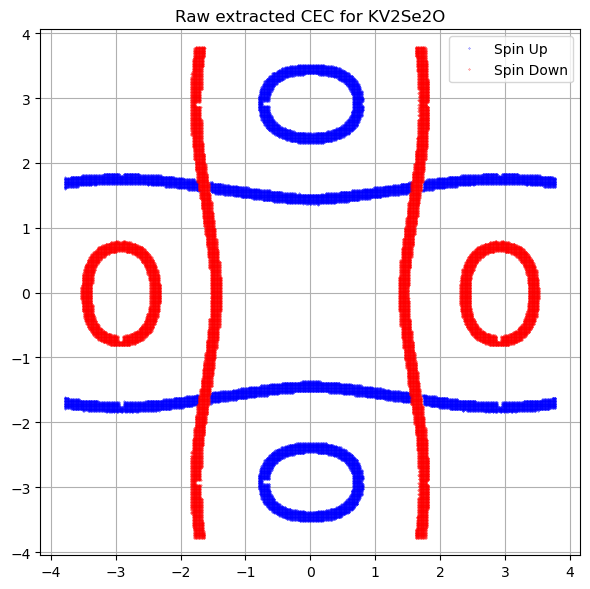

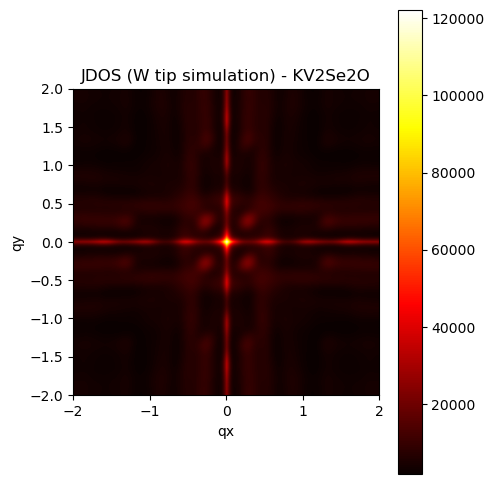

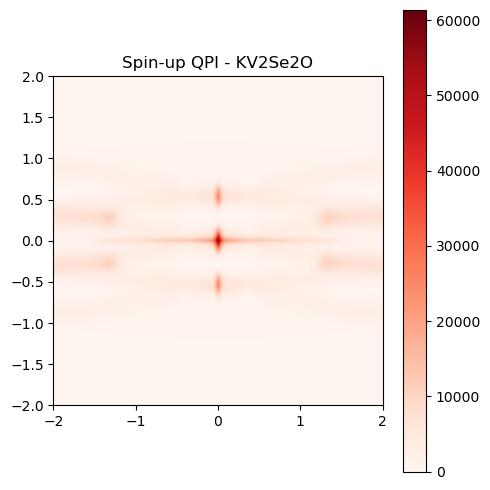

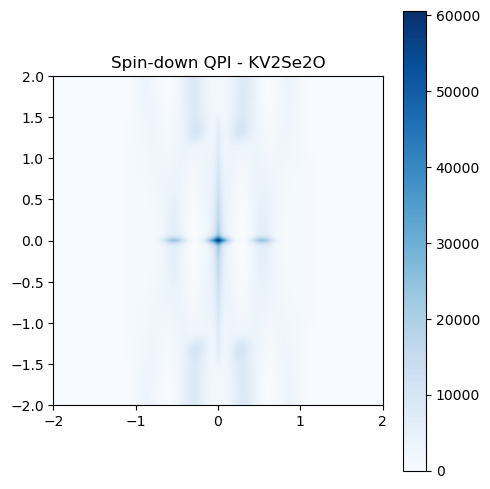

✅ All outputs saved to folder: d_wave_KV2Se2O


In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import io
import shutil
import os

input_image_path = "d_wave_KV2Se2O.png"
output_dir = "d_wave_KV2Se2O"
os.makedirs(output_dir, exist_ok=True)

shutil.copy(input_image_path, os.path.join(output_dir, os.path.basename(input_image_path)))

image = io.imread(input_image_path)
if image.shape[-1] == 4:
    image = image[:, :, :3]

red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

red_mask = (red_channel > 150) & (green_channel < 100) & (blue_channel < 100)
blue_mask = (blue_channel > 150) & (red_channel < 100) & (green_channel < 100)

red_y, red_x = np.where(red_mask)
blue_y, blue_x = np.where(blue_mask)

blue_x_norm = (blue_x - np.mean(blue_x)) / 180 * 2
blue_y_norm = (-blue_y - np.mean(-blue_y)) / 180 * 2

red_x_norm = (red_x - np.mean(red_x)) / 180 * 2
red_y_norm = (-red_y - np.mean(-red_y)) / 180 * 2

cec_up = np.vstack([blue_x_norm, blue_y_norm, np.ones_like(blue_x_norm)]).T
cec_dn = np.vstack([red_x_norm, red_y_norm, np.ones_like(red_x_norm)]).T

np.save(os.path.join(output_dir, "cec_up.npy"), cec_up)
np.save(os.path.join(output_dir, "cec_dn.npy"), cec_dn)

plt.figure(figsize=(6, 6))
plt.plot(cec_up[:, 0], cec_up[:, 1], 'b.', markersize=0.5, label='Spin Up')
plt.plot(cec_dn[:, 0], cec_dn[:, 1], 'r.', markersize=0.5, label='Spin Down')
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.title("Raw extracted CEC for KV2Se2O")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "Raw_extracted_CEC.png"), dpi=300)
plt.show()

def points_to_density_map(points, grid_size=512, k_range=2.0, sigma=5):
    kx, ky, I = points[:, 0], points[:, 1], points[:, 2]
    density = np.zeros((grid_size, grid_size))
    x = np.linspace(-k_range, k_range, grid_size)
    y = np.linspace(-k_range, k_range, grid_size)
    for i in range(len(kx)):
        ix = np.searchsorted(x, kx[i])
        iy = np.searchsorted(y, ky[i])
        if 0 <= ix < grid_size and 0 <= iy < grid_size:
            density[iy, ix] += I[i]
    return gaussian_filter(density, sigma=sigma)

def compute_jdos(density_map):
    fft = np.fft.fft2(density_map)
    return np.abs(np.fft.fftshift(np.fft.ifft2(np.abs(fft)**2)))

grid_size = 512
k_range = 2.0

map_up = points_to_density_map(cec_up, grid_size, k_range)
map_dn = points_to_density_map(cec_dn, grid_size, k_range)
map_total = map_up + map_dn

jdos_up = compute_jdos(map_up)
jdos_dn = compute_jdos(map_dn)
jdos_total = compute_jdos(map_total)

extent = [-k_range, k_range, -k_range, k_range]

plt.figure(figsize=(5, 5))
plt.imshow(jdos_total, cmap='hot', extent=extent)
plt.title("JDOS (W tip simulation) - KV2Se2O")
plt.xlabel("qx")
plt.ylabel("qy")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_Wtip.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_up, cmap='Reds', extent=extent)
plt.title("Spin-up QPI - KV2Se2O")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spinup.png"), dpi=300)

plt.figure(figsize=(5, 5))
plt.imshow(jdos_dn, cmap='Blues', extent=extent)
plt.title("Spin-down QPI - KV2Se2O")
plt.colorbar()
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "JDOS_spindn.png"), dpi=300)

plt.show()

print(f"✅ All outputs saved to folder: {output_dir}")


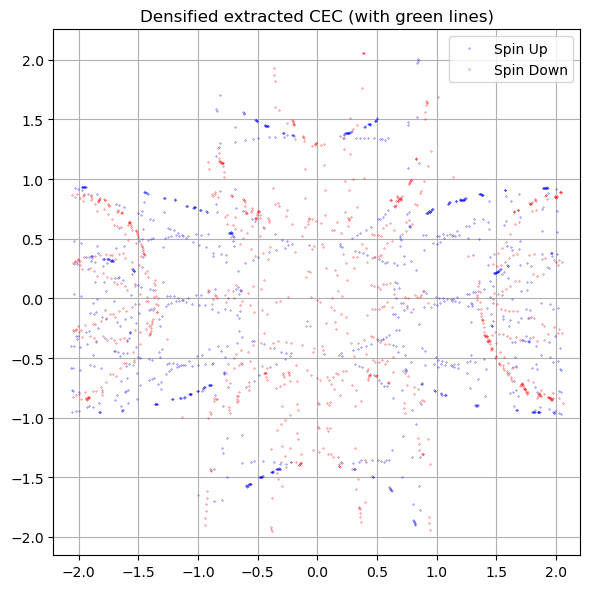

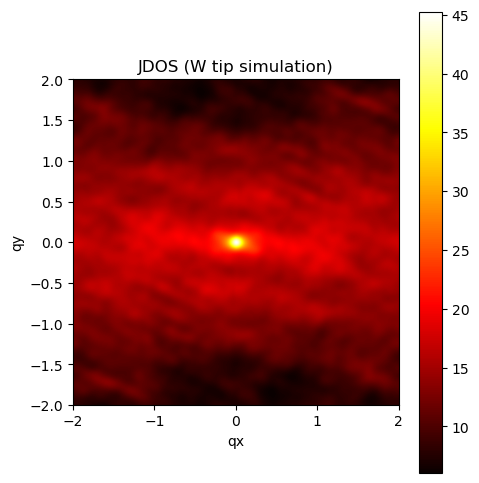

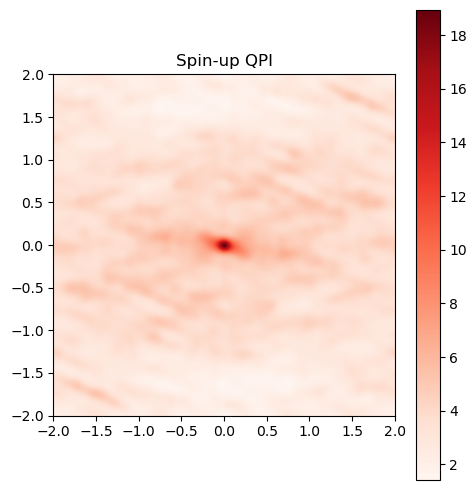

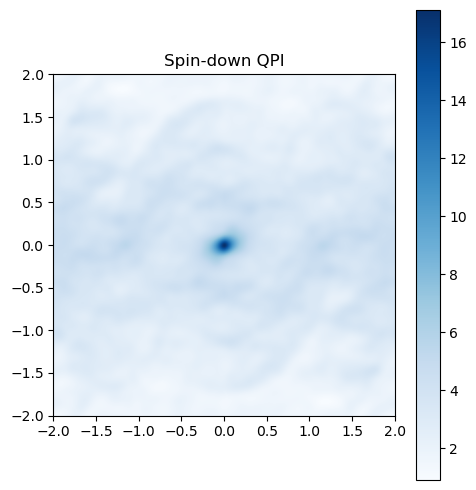

✅ All outputs saved to folder: d_wave_Rb1−δV2Te2O_dense


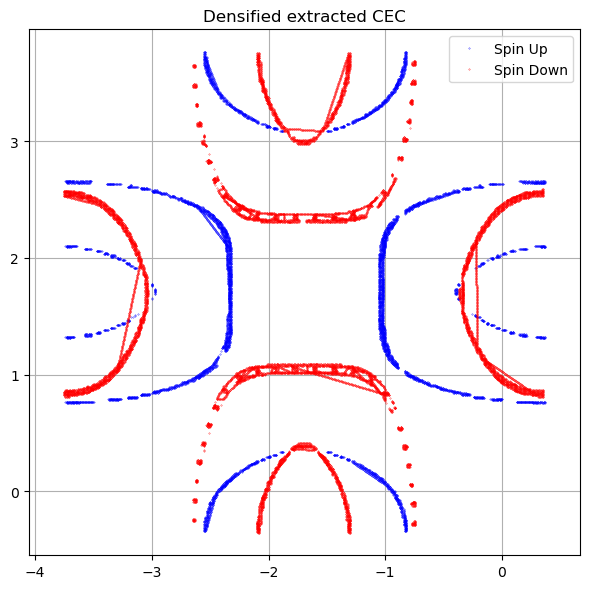

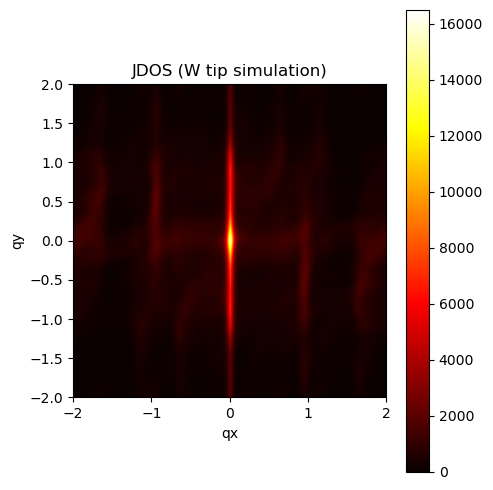

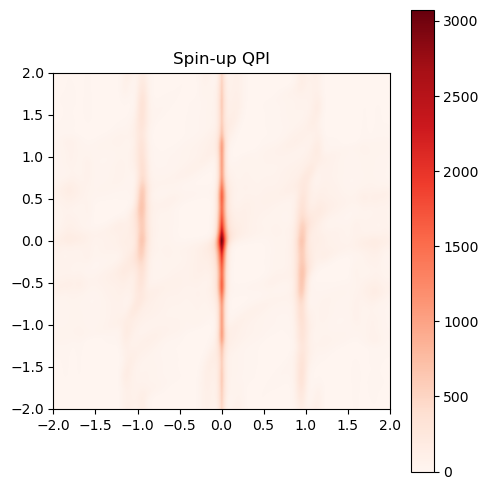

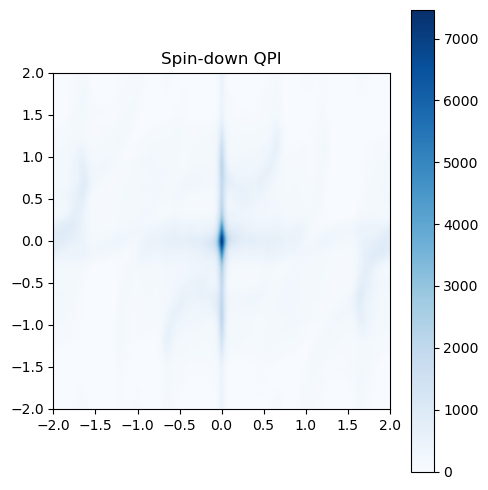

✅ All outputs saved to folder: d_wave_Rb1−δV2Te2O_dense
